In [18]:
from PIL import Image
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [19]:
csv_file_path = '../../dataset/aug_splits/1/val.csv'
pic_dir_path = '../../dataset/pictures'

In [20]:
df = pd.read_csv(csv_file_path)
df.head()

,fname,ammonia,chlorophyll,quality,ammonia_bin
0,../../dataset/pics/2020_02_20_3_Treat7_NoBag_2...,3.39,61.36,3,0
1,../../dataset/pics/augs/0-2020_02_20_3_Treat7_...,3.39,61.36,3,0
2,../../dataset/pics/augs/1-2020_02_20_3_Treat7_...,3.39,61.36,3,0
3,../../dataset/pics/augs/2-2020_02_20_3_Treat7_...,3.39,61.36,3,0
4,../../dataset/pics/augs/3-2020_02_20_3_Treat7_...,3.39,61.36,3,0


In [21]:
from agroalimentary_quality_control.modeling.dataset import RocketDataset, ContrastiveRocketDataset
from agroalimentary_quality_control.modeling.regressor import RocketRegressor

In [22]:
dataset = RocketDataset(df, 'ammonia', 'fname', 0.5)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [23]:
model = RocketRegressor(1081, '../models/pretrained/mobilenet_v2_weights_best_acc.tar', 'cpu')

  0%|          | 0/162 [00:00<?, ?it/s]

torch.Size([4, 3, 384, 512])
torch.Size([4, 1])
torch.Size([4, 1])


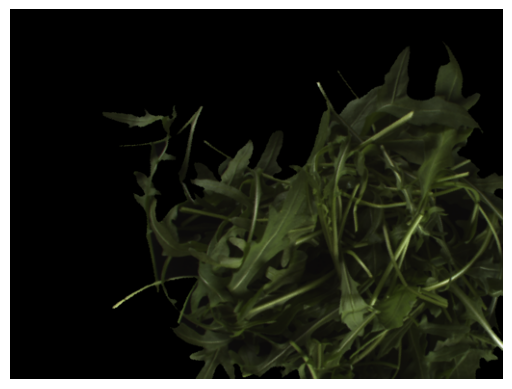

  0%|          | 0/162 [00:03<?, ?it/s]


In [24]:
for image, target in tqdm(loader):
    print(image.shape)
    pred, _ = model(image)
    print(pred.shape)
    print(target.shape)
    
    pic = image[0]
    pic = pic.permute(1, 2, 0)
    plt.imshow(pic.numpy())
    plt.axis('off')
    plt.show()
    
    break


In [25]:
import torch


def binning(target):
    quantiles = torch.quantile(target, torch.linspace(0, 1, steps=4))  # 5 steps for 4 bins
    bin_edges = quantiles.tolist()


    # Use torch.bucketize to find the bin index for each target element
    bin_indices = torch.bucketize(target, torch.tensor(bin_edges))

    return bin_indices

bin_indices = binning(target)

# Now you can query the bins directly using bin_indices
for i in range(4):
    print(target[bin_indices == i])


tensor([3.3900])
tensor([31.4000])
tensor([])
tensor([79.6400, 79.6400])


In [26]:
bin_indices

tensor([[0],
        [3],
        [1],
        [3]])

In [27]:
(bin_indices + 2) % 4

tensor([[2],
        [1],
        [3],
        [1]])

In [28]:
image[bin_indices]

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,

In [29]:
image.shape

torch.Size([4, 3, 384, 512])

In [30]:
num_bins = 4

for images, targets in tqdm(loader):
    quantiles = torch.quantile(targets, torch.linspace(0, 1, steps=num_bins))  # 5 steps for 4 bins
    bin_edges = quantiles.tolist()
    bin_indices = torch.bucketize(targets, torch.tensor(bin_edges))
    negative_bin_indices = (bin_indices + 2) % num_bins

    anchors = []
    negatives = []

    for i in range(len(images)):
        # Get the current bin and negative bin for the current image
        anchor_bin = bin_indices[i]
        negative_bin = negative_bin_indices[i]
        
        # Select a random anchor and a random negative from the corresponding bins
        anchor_indices = torch.where(bin_indices == anchor_bin)[0]
        negative_indices = torch.where(bin_indices == negative_bin)[0]
        
        # Randomly pick an anchor and a negative
        anchor_idx = anchor_indices[torch.randint(0, len(anchor_indices), (1,))]
        negative_idx = negative_indices[torch.randint(0, len(negative_indices), (1,))]
        
        # Fetch the selected anchor and negative images
        # Use direct indexing without extra dimensions
        anchor_image = images[anchor_idx].squeeze(0)  # Remove the singleton dimension
        negative_image = images[negative_idx].squeeze(0)  # Remove the singleton dimension
        
        # Append the anchor and negative to the respective lists
        anchors.append(anchor_image)
        negatives.append(negative_image)

    # Convert the list of anchors and negatives into tensors
    anchors = torch.stack(anchors)  # Shape: (total_count, c, h, w)
    negatives = torch.stack(negatives)  # Shape: (total_count, c, h, w)


  1%|          | 1/162 [00:01<03:33,  1.33s/it]


RuntimeError: random_ expects 'from' to be less than 'to', but got from=0 >= to=0

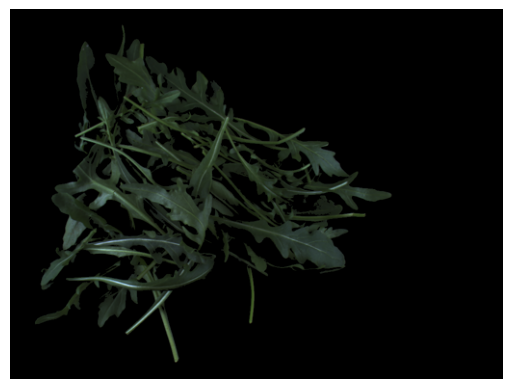

In [ ]:
pic = images[0]
pic = pic.permute(1, 2, 0)
plt.imshow(pic.numpy())
plt.axis('off')
plt.show()

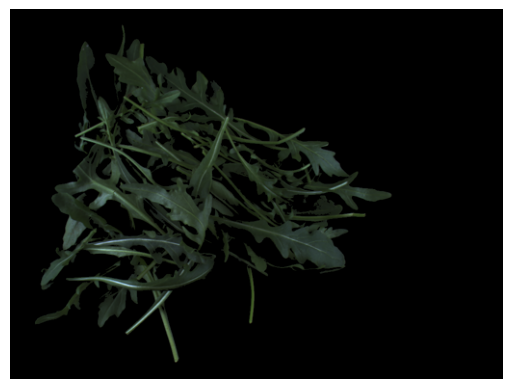

In [ ]:
pic = anchors[0]
pic = pic.permute(1, 2, 0)
plt.imshow(pic.numpy())
plt.axis('off')
plt.show()

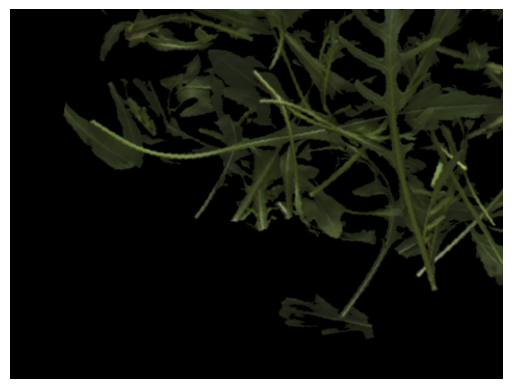

In [ ]:
pic = negatives[0]
pic = pic.permute(1, 2, 0)
plt.imshow(pic.numpy())
plt.axis('off')
plt.show()

In [37]:
import random

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)

n_bins = 4

for images, targets in tqdm(
    loader,
    desc="Training",
    leave=False
):
    quantiles = torch.quantile(targets, torch.linspace(0, 1, steps=n_bins))
    bin_edges = quantiles.tolist()
    bin_indices = torch.bucketize(targets, torch.tensor(bin_edges))
    negative_bin_indices = (bin_indices + (n_bins / 2)) % n_bins

    images_contrast = []
    labels = []

    for i in range(len(images)):
        anchor_bin = bin_indices[i]
        negative_bin = negative_bin_indices[i]
        
        anchor_indices = torch.where(bin_indices == anchor_bin)[0]
        negative_indices = torch.where(bin_indices == negative_bin)[0]

        if len(negative_indices) == 0 or torch.rand(1).item() < 0.5:
            anchor_idx = anchor_indices[torch.randint(0, len(anchor_indices), (1,))]
            anchor_image = images[anchor_idx].squeeze(0)
            images_contrast.append(anchor_image)
            labels.append(1)
        else:
            negative_idx = negative_indices[torch.randint(0, len(negative_indices), (1,))]
            negative_image = images[negative_idx].squeeze(0)
            images_contrast.append(negative_image)
            labels.append(-1)


    images_contrast = torch.stack(images_contrast)

    labels = torch.tensor(labels)
    tqdm.write(f'{labels}')

Training:   1%|          | 1/162 [00:00<00:49,  3.28it/s]

tensor([ 1,  1, -1, -1])


Training:   1%|          | 2/162 [00:00<00:46,  3.43it/s]

tensor([-1, -1,  1, -1])


Training:   2%|▏         | 3/162 [00:00<00:46,  3.38it/s]

tensor([-1,  1, -1,  1])


Training:   2%|▏         | 4/162 [00:01<00:45,  3.45it/s]

tensor([ 1, -1, -1,  1])


Training:   3%|▎         | 5/162 [00:01<00:44,  3.54it/s]

tensor([-1, -1, -1,  1])


Training:   4%|▎         | 6/162 [00:01<00:40,  3.88it/s]

tensor([ 1, -1,  1, -1])


Training:   4%|▍         | 7/162 [00:01<00:40,  3.83it/s]

tensor([ 1,  1,  1, -1])


Training:   5%|▍         | 8/162 [00:02<00:39,  3.88it/s]

tensor([-1, -1, -1,  1])


Training:   6%|▌         | 9/162 [00:02<00:41,  3.71it/s]

tensor([1, 1, 1, 1])


Training:   6%|▌         | 10/162 [00:02<00:43,  3.53it/s]

tensor([-1,  1,  1,  1])


Training:   7%|▋         | 11/162 [00:03<00:44,  3.43it/s]

tensor([-1,  1, -1, -1])


Training:   7%|▋         | 12/162 [00:03<00:43,  3.44it/s]

tensor([ 1,  1, -1,  1])


Training:   8%|▊         | 13/162 [00:03<00:43,  3.44it/s]

tensor([-1,  1,  1,  1])


Training:   9%|▊         | 14/162 [00:03<00:39,  3.77it/s]

tensor([ 1,  1, -1,  1])


Training:   9%|▉         | 15/162 [00:04<00:44,  3.32it/s]

tensor([ 1,  1, -1,  1])


Training:  10%|▉         | 16/162 [00:04<00:41,  3.53it/s]

tensor([ 1, -1,  1, -1])


Training:  10%|█         | 17/162 [00:04<00:43,  3.37it/s]

tensor([ 1,  1,  1, -1])


Training:  11%|█         | 18/162 [00:05<00:42,  3.38it/s]

tensor([-1,  1,  1,  1])


Training:  12%|█▏        | 19/162 [00:05<00:39,  3.61it/s]

tensor([-1, -1, -1,  1])


Training:  12%|█▏        | 20/162 [00:05<00:36,  3.88it/s]

tensor([ 1, -1, -1, -1])


Training:  13%|█▎        | 21/162 [00:05<00:37,  3.79it/s]

tensor([ 1, -1, -1,  1])


Training:  14%|█▎        | 22/162 [00:06<00:38,  3.65it/s]

tensor([ 1, -1, -1, -1])


Training:  14%|█▍        | 23/162 [00:06<00:40,  3.44it/s]

tensor([ 1, -1,  1, -1])


Training:  15%|█▍        | 24/162 [00:06<00:43,  3.17it/s]

tensor([ 1,  1, -1,  1])


Training:  15%|█▌        | 25/162 [00:07<00:44,  3.11it/s]

tensor([ 1, -1, -1, -1])


Training:  16%|█▌        | 26/162 [00:07<00:41,  3.27it/s]

tensor([ 1,  1, -1,  1])


Training:  17%|█▋        | 27/162 [00:07<00:43,  3.13it/s]

tensor([1, 1, 1, 1])


Training:  17%|█▋        | 28/162 [00:08<00:45,  2.97it/s]

tensor([ 1, -1,  1,  1])


Training:  18%|█▊        | 29/162 [00:08<00:45,  2.95it/s]

tensor([ 1, -1, -1,  1])


Training:  19%|█▊        | 30/162 [00:08<00:43,  3.05it/s]

tensor([ 1, -1, -1,  1])


Training:  19%|█▉        | 31/162 [00:09<00:43,  3.01it/s]

tensor([ 1,  1, -1,  1])


Training:  20%|█▉        | 32/162 [00:09<00:44,  2.92it/s]

tensor([ 1,  1, -1, -1])


Training:  20%|██        | 33/162 [00:09<00:43,  2.96it/s]

tensor([1, 1, 1, 1])


Training:  21%|██        | 34/162 [00:10<00:43,  2.94it/s]

tensor([1, 1, 1, 1])


Training:  22%|██▏       | 35/162 [00:10<00:44,  2.87it/s]

tensor([ 1,  1, -1, -1])


Training:  22%|██▏       | 36/162 [00:10<00:46,  2.72it/s]

tensor([-1, -1, -1,  1])


tensor([ 1,  1,  1, -1])


KeyboardInterrupt: 

In [ ]:
labels

In [32]:
model(images)[1].shape

torch.Size([4, 128])

In [13]:
from torch.nn import CosineEmbeddingLoss

In [ ]:
_, img_emb = model(images)
_, con_emb = model(images_contrast)

In [ ]:
loss_fn = CosineEmbeddingLoss()

loss_fn(img_emb, con_emb, labels)

tensor(0.4850, grad_fn=<MeanBackward0>)